In [111]:
%matplotlib inline

# CQR Comparison


In [112]:
import warnings

from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, AnnotationBbox
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.datasets import (
    fetch_california_housing, load_diabetes, make_regression,
    make_sparse_uncorrelated, make_friedman1, make_friedman2, make_friedman3
)
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import randint, uniform

from mapie.metrics import (
    regression_coverage_score,
    regression_mean_width_score
    )
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample
from mapie.quantile_regression import MapieQuantileRegressor


random_state = 23
rng = np.random.default_rng(random_state)
round_to = 3

warnings.filterwarnings("ignore")

## 1. Datasets


In [161]:
def get_data(name, n_samples=1000, n_features=10):
    if name == "california":
        data = fetch_california_housing(as_frame=True)
        X = pd.DataFrame(data=data.data, columns=data.feature_names)
        y = pd.DataFrame(data=data.target)
    elif name == "diabetes":
        data = load_diabetes(as_frame=True)
        X = pd.DataFrame(data=data.data, columns=data.feature_names)
        y = pd.DataFrame(data=data.target)['target']
    elif name == "make_regression":
        data = make_regression(n_samples, n_features)
        X = pd.DataFrame(data[0])
        y = pd.DataFrame(data[1].reshape(-1, 1))
    elif name == "sparse_uncorrelated":
        data = make_sparse_uncorrelated(n_samples, n_features)
        X = pd.DataFrame(data[0])
        y = pd.DataFrame(data[1].reshape(-1, 1))
    elif name == "friedman1":
        data = make_friedman1(n_samples, n_features)
        X = pd.DataFrame(data[0])
        y = pd.DataFrame(data[1].reshape(-1, 1))
    elif name == "friedman2":
        data = make_friedman2(n_samples)
        X = pd.DataFrame(data[0])
        y = pd.DataFrame(data[1].reshape(-1, 1))
    elif name == "friedman3":
        data = make_friedman3(n_samples)
        X = pd.DataFrame(data[0])
        y = pd.DataFrame(data[1].reshape(-1, 1))
    elif name == "heteroscedastic":
        X = np.linspace(0, 5, n_samples)
        y = pd.DataFrame((((3*X)+5) + (np.random.normal(0, 1, len(X)) * X)).reshape(-1, 1))
        X = pd.DataFrame(X)
        # X = X.reshape(-1, 1)
    elif name == "homoscedastic":
        X = np.linspace(0, 5, n_samples)
        y = pd.DataFrame((((3*X)+5) + (np.random.normal(0, 1, len(X)))).reshape(-1, 1))
        X = pd.DataFrame(X)
        # X = X.reshape(-1, 1)
    return X, y

In [178]:
name = "california"
X, y = get_data(name)

In [181]:
# plt.scatter(X, y)
# plt.title(name)
# plt.xlabel("X")
# plt.ylabel("y")
# plt.savefig("images/"+name+".png")

Let's visualize the dataset by showing the correlations between the
independent variables.



In [182]:
df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Now let's visualize a histogram of the price of the houses.



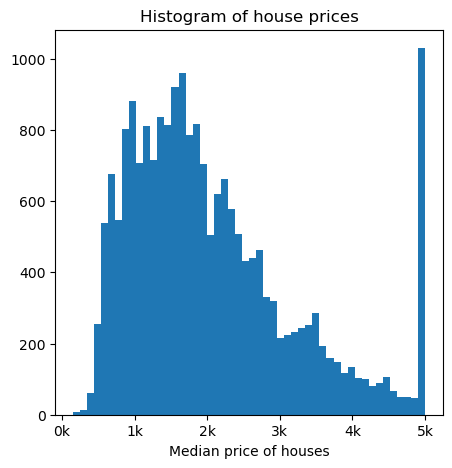

In [183]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(y, bins=50)
axs.set_xlabel("Median price of houses")
axs.set_title("Histogram of house prices")
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
plt.show()

Let's now create the different splits for the dataset, with a training,
calibration and test set. Recall that the calibration set is used for
calibrating the prediction intervals.



In [184]:
y.shape

(20640, 1)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=random_state
)
X_train, X_calib, y_train, y_calib = train_test_split(
    X_train,
    y_train,
    random_state=random_state
)

## 2. Optimizing estimator
Before estimating uncertainties, let's start by optimizing the base model
in order to reduce our prediction error. We will use the
:class:`~lightgbm.LGBMRegressor` in the quantile setting. The optimization
is performed using :class:`~sklearn.model_selection.RandomizedSearchCV`
to find the optimal model to predict the house prices.



In [186]:
estimator = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    random_state=random_state
)
params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=300),
    learning_rate=uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=100,
    cv=KFold(n_splits=5, shuffle=True),
    verbose=-1
)
optim_model.fit(X_train, y_train)
estimator = optim_model.best_estimator_

## 3. Comparison of MAPIE methods
We will now proceed to compare the different methods available in MAPIE used
for uncertainty quantification on regression settings. For this tutorial we
will compare the "naive", "Jackknife plus after Bootstrap", "cv plus" and
"conformalized quantile regression". Please have a look at the theoretical
description of the documentation for more details on these methods.

We also create two functions, one to sort the dataset in increasing values
of ``y_test`` and a plotting function, so that we can plot all predictions
and prediction intervals for different conformal methods.



In [187]:
def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=error[~warnings],
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        label="Inside prediction interval"
        )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=error[warnings],
        capsize=5, marker="o", elinewidth=2, linewidth=0, color="red",
        label="Outside prediction interval"
        )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*", color="green",
        label="True value"
    )
    axs.set_xlabel("True house prices in $")
    axs.set_ylabel("Prediction of house prices in $")
    ab = AnnotationBbox(
        TextArea(
            f"Coverage: {np.round(coverage, round_to)}\n"
            + f"Interval width: {np.round(width, round_to)}"
        ),
        xy=(np.min(y_test_sorted_)*3, np.max(y_pred_sorted_+error)*0.95),
        )
    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
        np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes
    ]
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold')

We proceed to using MAPIE to return the predictions and prediction intervals.
We will use an $\alpha=0.2$, this means a target coverage of 0.8
(recall that this parameter needs to be initialized directly when setting
:class:`~mapie.quantile_regression.MapieQuantileRegressor` and when using
:class:`~mapie.regression.MapieRegressor`, it needs to be set in the
``predict``).
Note that for the CQR, there are two options for ``cv``:

* ``cv="split"`` (by default), the split-conformal where MAPIE trains the
  model on a training set and then calibrates on the calibration set.
* ``cv="prefit"`` meaning that you can train your models with the correct
  quantile values (must be given in the following order:
  $(\alpha, 1-(\alpha/2), 0.5)$ and given to MAPIE as an iterable
  object. (Check the examples for how to use prefit in MAPIE)

Additionally, note that there is a list of accepted models by
:class:`~mapie.quantile_regression.MapieQuantileRegressor`
(``quantile_estimator_params``) and that we will use symmetrical residuals.



In [188]:
STRATEGIES = {
    "naive": {"method": "naive"},
    "cv_plus": {"method": "plus", "cv": 10},
    "jackknife_plus_ab": {"method": "plus", "cv": Subsample(n_resamplings=50)},
    "cqr": {"method": "quantile", "cv": "split", "alpha": 0.2},
}
y_pred, y_pis = {}, {}
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
coverage, width = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "cqr":
        mapie = MapieQuantileRegressor(estimator, **params)
        mapie.fit(X_train, y_train, X_calib=X_calib, y_calib=y_calib)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:
        mapie = MapieRegressor(estimator, **params)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.2)
    (
        y_test_sorted[strategy],
        y_pred_sorted[strategy],
        lower_bound[strategy],
        upper_bound[strategy]
    ) = sort_y_values(y_test, y_pred[strategy], y_pis[strategy])
    coverage[strategy] = regression_coverage_score(
        y_test,
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        )
    width[strategy] = regression_mean_width_score(
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        )

We will now proceed to the plotting stage, note that we only plot 2% of the
observations in order to not crowd the plot too much.



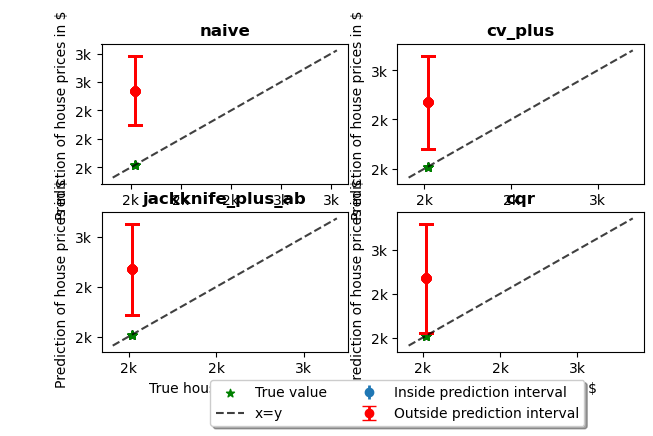

In [189]:
perc_obs_plot = 0.02
num_plots = rng.choice(
    len(y_test), int(perc_obs_plot*len(y_test)), replace=False
    )
fig, axs = plt.subplots(2, 2, figsize=(7, 4))
coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
for strategy, coord in zip(STRATEGIES.keys(), coords):
    plot_prediction_intervals(
        strategy,
        coord,
        y_test_sorted[strategy],
        y_pred_sorted[strategy],
        lower_bound[strategy],
        upper_bound[strategy],
        coverage[strategy],
        width[strategy],
        num_plots
        )
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(_, []) for _ in zip(*lines_labels)]
plt.legend(
    lines[:4], labels[:4],
    loc='upper center',
    bbox_to_anchor=(0, -0.15),
    fancybox=True,
    shadow=True,
    ncol=2
)
plt.show()

We notice more adaptability of the prediction intervals for the
conformalized quantile regression while the other methods have fixed
interval width. Indeed, as the prices get larger, the prediction intervals
are increased with the increase in price.



In [60]:
def get_coverages_widths_by_bins(
    want,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins
):
    """
    Given the results from MAPIE, this function split the data
    according the the test values into bins and calculates coverage
    or width per bin.
    """
    cuts = []
    cuts_ = pd.qcut(y_test["naive"], bins).unique()[:-1]
    for item in cuts_:
        cuts.append(item.left)
    cuts.append(cuts_[-1].right)
    cuts.append(np.max(y_test["naive"])+1)
    recap = {}
    for i in range(len(cuts) - 1):
        cut1, cut2 = cuts[i], cuts[i+1]
        name = f"[{np.round(cut1, 0)}, {np.round(cut2, 0)}]"
        recap[name] = []
        for strategy in STRATEGIES:
            indices = np.where(
                (y_test[strategy] > cut1) * (y_test[strategy] <= cut2)
                )
            y_test_trunc = np.take(y_test[strategy], indices)
            y_low_ = np.take(lower_bound[strategy], indices)
            y_high_ = np.take(upper_bound[strategy], indices)
            if want == "coverage":
                recap[name].append(regression_coverage_score(
                    y_test_trunc[0],
                    y_low_[0],
                    y_high_[0]
                ))
            elif want == "width":
                recap[name].append(
                    regression_mean_width_score(y_low_[0], y_high_[0])
                )
    recap_df = pd.DataFrame(recap, index=STRATEGIES)
    return recap_df


bins = list(np.arange(0, 1, 0.1))
binned_data = get_coverages_widths_by_bins(
    "coverage",
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins
)

ValueError: Input array must be 1 dimensional

To confirm these insights, we will now observe what happens when we plot
the conditional coverage and interval width on these intervals splitted by
quantiles.



In [ ]:
binned_data.T.plot.bar(figsize=(12, 4))
plt.axhline(0.80, ls="--", color="k")
plt.ylabel("Conditional coverage")
plt.xlabel("Binned house prices")
plt.xticks(rotation=345)
plt.ylim(0.3, 1.0)
plt.legend(loc=[1, 0])
plt.show()

What we observe from these results is that none of the methods seems to
have conditional coverage at the target $1 - \alpha$. However, we can
clearly notice that the CQR seems to better adapt to large prices. Its
conditional coverage is closer to the target coverage not only for higher
prices, but also for lower prices where the other methods have a higher
coverage than needed. This will very likely have an impact on the widths
of the intervals.



In [ ]:
binned_data = get_coverages_widths_by_bins(
    "width",
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins
)


binned_data.T.plot.bar(figsize=(12, 4))
plt.ylabel("Interval width")
plt.xlabel("Binned house prices")
plt.xticks(rotation=350)
plt.legend(loc=[1, 0])
plt.show()

When observing the values of the the interval width we again see what was
observed in the previous graphs with the interval widths. We can again see
that the prediction intervals are larger as the price of the houses
increases, interestingly, it's important to note that the prediction
intervals are shorter when the estimator is more certain.

